In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from flask import Flask, jsonify

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [4]:
#data = engine.execute("SELECT * FROM hawaii")
# #database_path = "../Resources/hawaii.sqlite"

In [6]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()



In [8]:
# reflect the tables
#Base.prepare(autoload_with=engine)
Base.prepare(engine, reflect=True)



In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Base.prepare(autoload_with=engine)

C:\Users\jillf\AppData\Local\Temp\ipykernel_3820\925212133.py:2: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  Base.prepare(autoload_with=engine)
C:\Users\jillf\AppData\Local\Temp\ipykernel_3820\925212133.py:2: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  Base.prepare(autoload_with=engine)


In [11]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [14]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date


('2017-08-23',)

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date=dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

In [18]:
# Calculate the date one year from the last date in data set.
last_12_months=most_recent_date - dt.timedelta(days=365)
last_12_months=last_12_months.date()

In [19]:

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12_months)
    #order_by(Measurement.date).all()

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"]).set_index('Date')

In [21]:
# Sort the dataframe by date
prcp_df.sort_values(by='Date',ascending=True,inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: 'Images/Precipitation.png'

<Figure size 432x288 with 0 Axes>

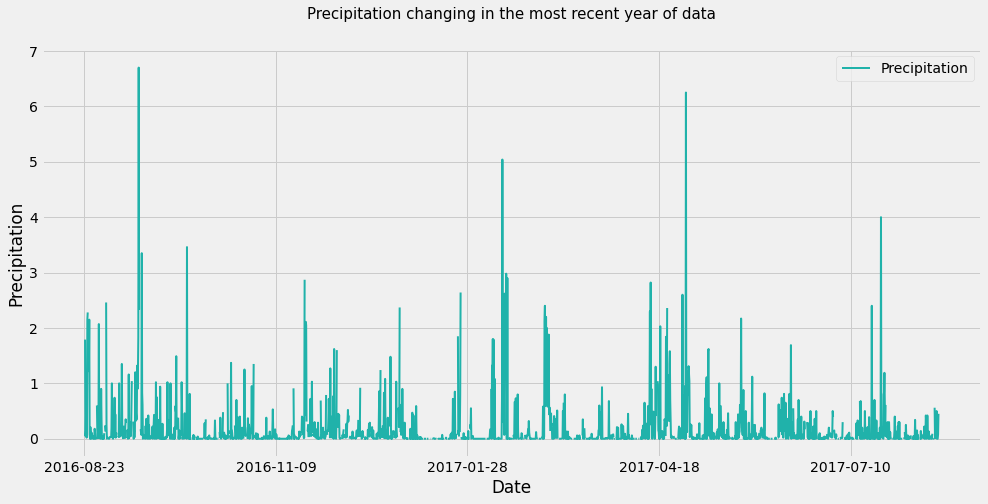

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
prcp_df.plot(figsize=(15,7),linewidth=2,color='lightseagreen')
plt.title('Precipitation changing in the most recent year of data',fontsize= 15,pad=30)
plt.ylabel('Precipitation')
plt.savefig('Images/Precipitation.png') 
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [25]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_one = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

USC00519281_ = session.query(*station_one).filter(Measurement.station == "USC00519281").all()
pd.DataFrame(USC00519281_,columns=['min','max','avg'],index=['USC00519281_'])

,min,max,avg
USC00519281_,54.0,85.0,71.663781


In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tob_active = session.query(Measurement.tobs).filter(Measurement.date >= last_12_months).filter(Measurement.station == "USC00519281").order_by(Measurement.date).all()
tob_active_df = pd.DataFrame(tob_active, columns=["tobs"])
tob_active_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


FileNotFoundError: [Errno 2] No such file or directory: 'Images/station-histogram.png'

<Figure size 1440x504 with 0 Axes>

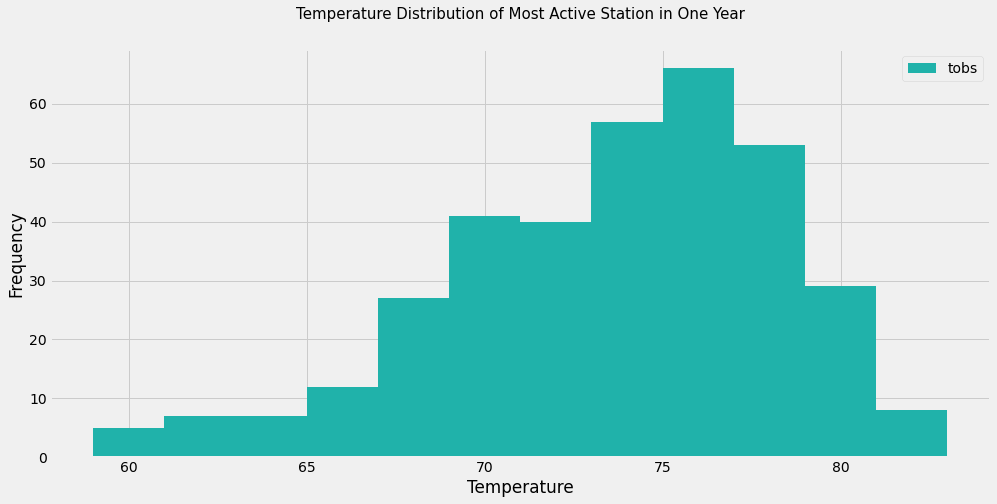

In [28]:
plt.figure(figsize=(20,7))
tob_active_df.plot.hist(bins=12,color='lightseagreen')
plt.title('Temperature Distribution of Most Active Station in One Year',fontsize= 15,pad=30)
plt.xlabel('Temperature')
plt.gcf().set_size_inches(15, 7)
plt.savefig('Images/station-histogram.png') 
plt.show()

# Close session

In [ ]:
# Close Session
session.close()